<a href="https://colab.research.google.com/github/TatKhachatryan/Time-Series-Analysis-Project/blob/main/ts_analysis_food_prices_arm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
!pip install -U kaleido
import condacolab
condacolab.install()
!conda install -c plotly python-kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✨🍰✨ Everything looks OK!
Solving environment: - \ | / - \ | / - \ | / - \ | / - done

# All requested packages already installed.



In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# data source: https://data.humdata.org/dataset/wfp-food-prices-for-armenia

data = pd.read_csv('/content/drive/MyDrive/Food_Prices_Armenia/wfp_food_prices_arm.csv')
data

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2487
2,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,130.0,0.3233
3,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2484
4,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,120.0,0.2981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35392,2023-08-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Cabbage,KG,forecast,Retail,AMD,0.0,0.0
35393,2023-08-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Carrots,KG,forecast,Retail,AMD,0.0,0.0
35394,2023-08-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Cucumbers (greenhouse),KG,forecast,Retail,AMD,0.0,0.0
35395,2023-08-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Onions,KG,forecast,Retail,AMD,0.0,0.0


So the columns' descriptions are:

*   **date** - baldate
*   **admin1** - province (region)
*   **admin2** - city/village/region names
*   **market** - local market name
*   **latitude** - geographic measure
*   **longitude** - geographic measure
*   **category** - item type
*   **commodity** - item name
*   **unit** - item unit
*   **priceflag** - item price flag
*   **pricetype** - item price type
*   **currency** - item currency
*   **price** - item price value
*   **usdprice** - item price value in usd




In [4]:
# dropping the first unnecessary row
data = data.iloc[1:]

# changing the column names to more friendly names
data.columns = ['Date', 'Province', 'Area', 'Market', 'Latitude', 'Longitude',
       'Item Category', 'Item Name', 'Unit', 'Priceflag', 'Pricetype', 'Currency',
       'Price', 'USD_price']

data = data[data['Priceflag']!='forecast']
data = data.reset_index(drop=True)

# Data Processing
## Missing Values

In [5]:
missing_values = data.isna().sum()
missing_values[missing_values>0]

Province     306
Area         306
Latitude     306
Longitude    306
dtype: int64

In [6]:
print("Market Names:", data[data['Province'].isnull()]['Market'].unique())
print("Item Names:", data[data['Province'].isnull()]['Item Name'].unique())
print()

data[data['Province'].isnull()].head()

Market Names: ['National Average']
Item Names: ['Fuel (diesel)' 'Fuel (petrol-gasoline)' 'Exchange rate']



,Date,Province,Area,Market,Latitude,Longitude,Item Category,Item Name,Unit,Priceflag,Pricetype,Currency,Price,USD_price
0,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2487
1,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,130.0,0.3233
2,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2484
3,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,120.0,0.2981
4,1996-03-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,110.0,0.2726


So, the reason that we have 324 missing values is caused by Market Name called **"National Average"**, which is logical,
as "National Average" can not have a geographical latitude/longtitude or Province and Area.

In [7]:
# data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           27550 non-null  object
 1   Province       27244 non-null  object
 2   Area           27244 non-null  object
 3   Market         27550 non-null  object
 4   Latitude       27244 non-null  object
 5   Longitude      27244 non-null  object
 6   Item Category  27550 non-null  object
 7   Item Name      27550 non-null  object
 8   Unit           27550 non-null  object
 9   Priceflag      27550 non-null  object
 10  Pricetype      27550 non-null  object
 11  Currency       27550 non-null  object
 12  Price          27550 non-null  object
 13  USD_price      27550 non-null  object
dtypes: object(14)
memory usage: 2.9+ MB


In [8]:
# convert object types to their corresponding types
data['Date'] = pd.to_datetime(data['Date'])
data['Price'] = data['Price'].astype(float)
data['USD_price'] = data['USD_price'].astype(float)

In [9]:
# new features from existing ones for EDA
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month_name()
data['Quarter'] = pd.PeriodIndex(data['Date'], freq='Q')

now = datetime.datetime.now()
data['Year_Range'] = now.year-data['Year']

data = data[data['Year']!=2023]
data['Date_Month'] = pd.to_datetime(data['Date']).dt.to_period('M')
data

,Date,Province,Area,Market,Latitude,Longitude,Item Category,Item Name,Unit,Priceflag,Pricetype,Currency,Price,USD_price,Year,Month,Quarter,Year_Range,Date_Month
0,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2487,1996,January,1996Q1,27,1996-01
1,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,130.0,0.3233,1996,January,1996Q1,27,1996-01
2,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2484,1996,February,1996Q1,27,1996-02
3,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,120.0,0.2981,1996,February,1996Q1,27,1996-02
4,1996-03-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,110.0,0.2726,1996,March,1996Q1,27,1996-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26848,2022-12-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Cabbage,KG,actual,Retail,AMD,146.2,0.3708,2022,December,2022Q4,1,2022-12
26849,2022-12-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Carrots,KG,actual,Retail,AMD,342.6,0.8690,2022,December,2022Q4,1,2022-12
26850,2022-12-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Cucumbers (greenhouse),KG,actual,Retail,AMD,1025.4,2.6009,2022,December,2022Q4,1,2022-12
26851,2022-12-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Onions,KG,actual,Retail,AMD,306.6,0.7777,2022,December,2022Q4,1,2022-12


# Exploratory Data Analysis

In [10]:
# defining the visualization's color scheme
colorScheme = [ "#386641", "#6A994E", "#A7C957", "#F2E8CF", "#BC4749", '#001219', '#E9D8A6','#EE9B00','#CA6702','#BB3E03','#AE2012','#9B2226', '#001219', '#005F73','#0A9396','#94D2BD']

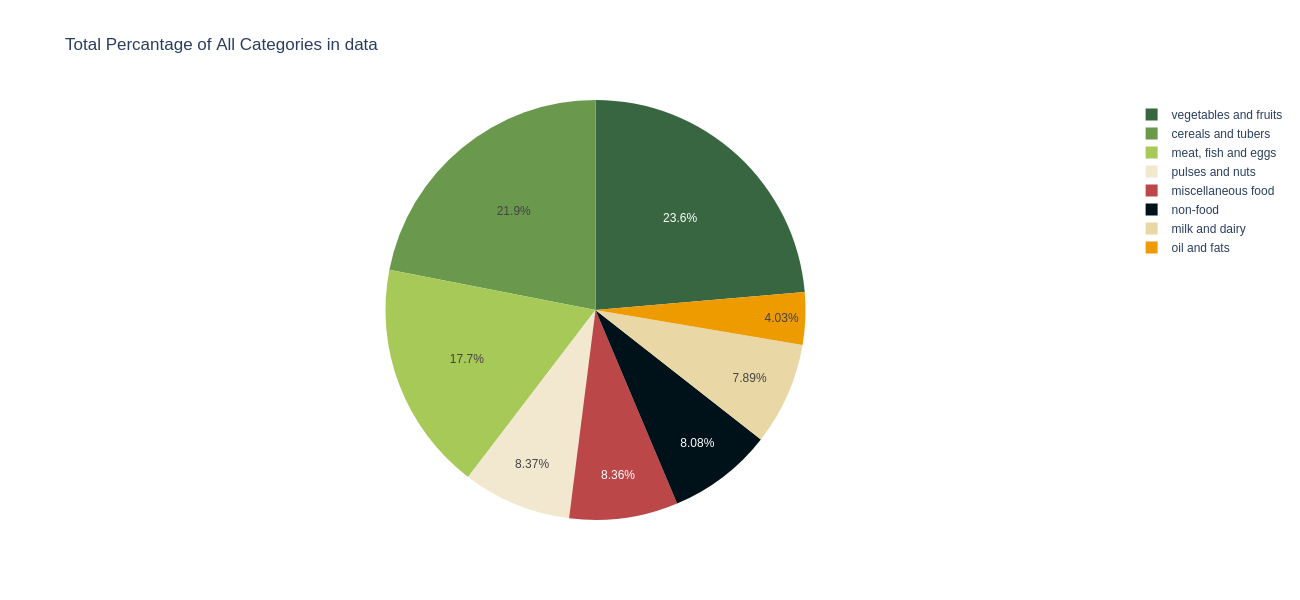

In [11]:
itemCategories = data['Item Category'].value_counts()

pieFig = px.pie(itemCategories,
                names=itemCategories.index,
                values=itemCategories.values,
                title='Total Percantage of All Categories in data',
                color_discrete_sequence=colorScheme)
pieFig.update_layout(autosize=False,
                  width=1300,
                  height=600)
pieFig.show(renderer='png')

## Milk Prices Total

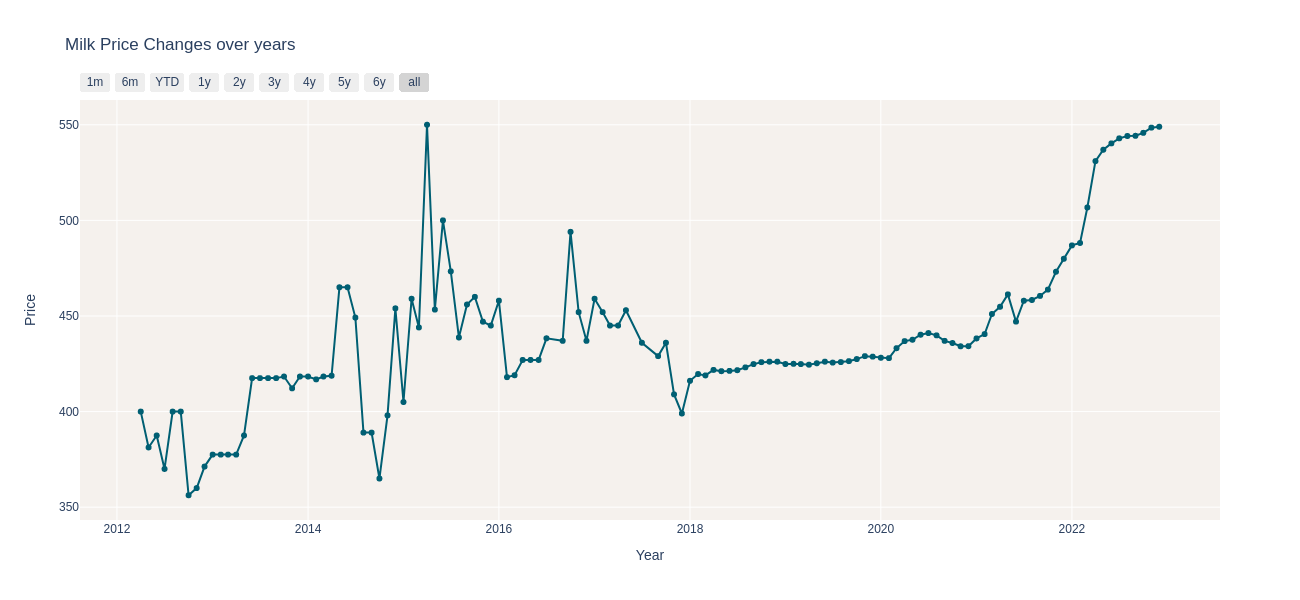

In [12]:
milkData = data[data['Item Name']=='Milk']
milkData = milkData.groupby('Date_Month')['Price'].mean().to_frame()
milkData = milkData.reset_index()


fig = go.Figure(data=go.Scatter(x=milkData['Date_Month'].astype(dtype=str),
                                y=milkData['Price'],
                                marker_color='#005F73',
                                text="counts",
                                mode='lines+markers'))

fig.update_layout(autosize=False,
                  width=1300,
                  height=600,
                  title = 'Milk Price Changes over years',
                  xaxis={"title":"Year"},
                  yaxis= {"title":"Price"},
                  showlegend=False,
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    #rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show() #<- this way the graph is interactive and we have an options to choose between ranges: 1 month, 6 month etc.
fig.show(renderer="png")

## Milk Prices by Regions

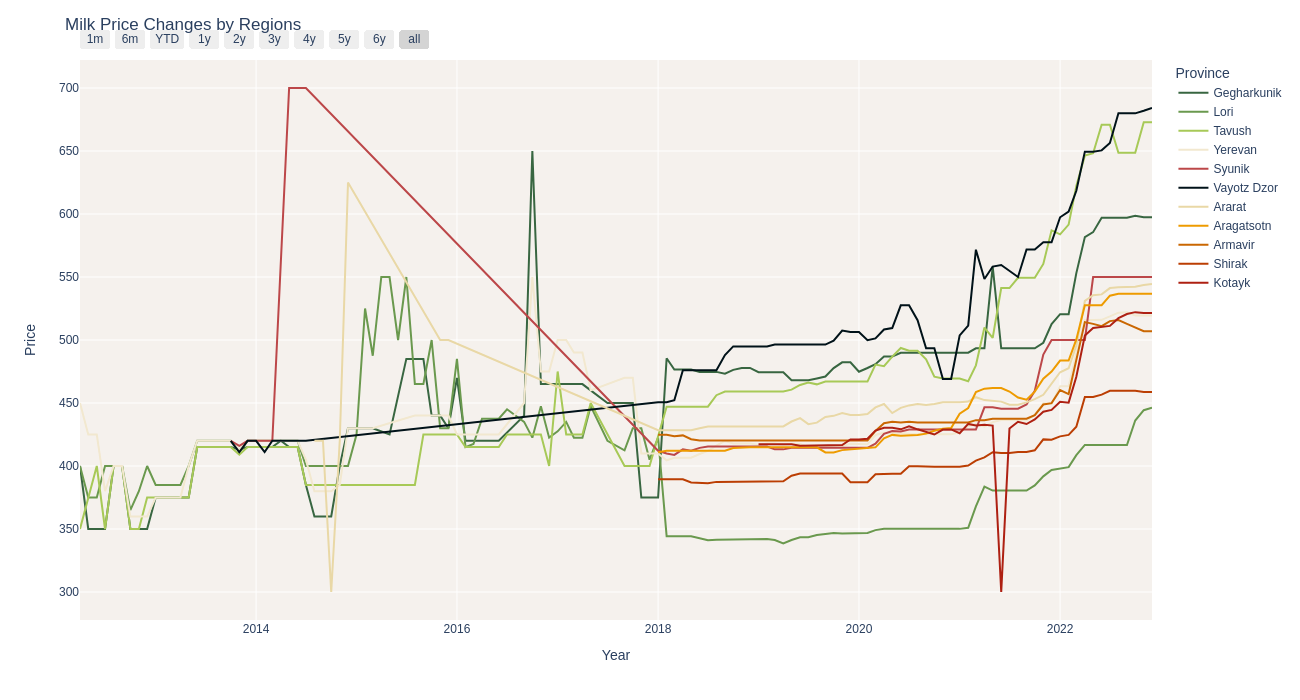

In [13]:
milkData_regions = data[data['Item Name']=='Milk']
milkData_regions = milkData_regions.groupby(['Date_Month', 'Province'])['Price'].mean().to_frame()
milkData_regions = milkData_regions.reset_index()

fig = px.line(milkData_regions, x=milkData_regions['Date_Month'].astype(dtype=str), y=milkData_regions['Price'], color=milkData_regions['Province'], color_discrete_sequence=colorScheme)
fig.update_layout(autosize=False,
                  width=1300,
                  height=700,
                  title = 'Milk Price Changes by Regions',
                  xaxis={"title":"Year"},
                  yaxis= {"title":"Price"},
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    #rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show() #<- this way the graph is interactive and we have an options to choose between ranges: 1 month, 6 month etc.
fig.show(renderer="png")

## Salt Prices Total

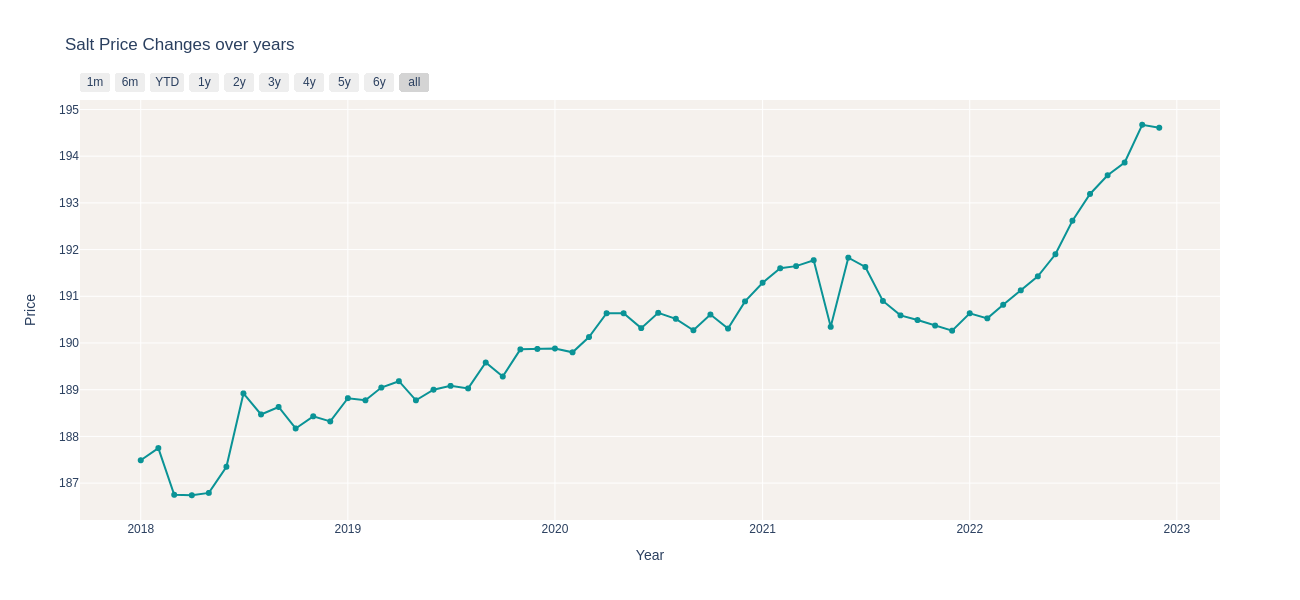

In [14]:
saltData = data[data['Item Name']=='Salt']
saltData = saltData.groupby(['Date_Month'])['Price'].mean().to_frame()
saltData = saltData.reset_index()

fig = go.Figure(data=go.Scatter(x=saltData['Date_Month'].astype(dtype=str),
                                y=saltData['Price'],
                                marker_color='#0A9396',
                                text="counts",
                                mode='lines+markers'))

fig.update_layout(autosize=False,
                  width=1300,
                  height=600,
                  title = 'Salt Price Changes over years',
                  xaxis={"title":"Year"},
                  yaxis= {"title":"Price"},
                  showlegend=False,
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show() #<- this way the graph is interactive and we have an options to choose between ranges: 1 month, 6 month etc.
fig.show(renderer="png")

## Salt Prices by Regions

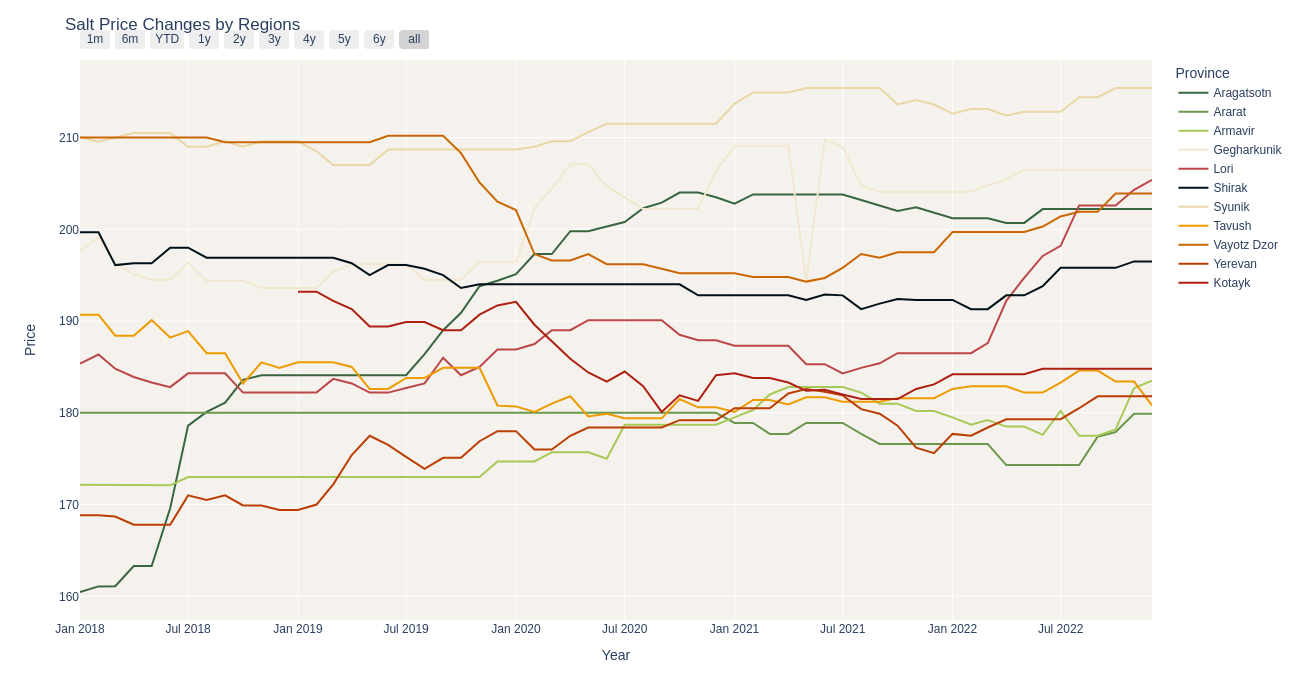

In [15]:
saltData_regions = data[data['Item Name']=='Salt']
saltData_regions = saltData_regions.groupby(['Date_Month', 'Province'])['Price'].mean().to_frame()
saltData_regions = saltData_regions.reset_index()

fig = px.line(saltData_regions, x=saltData_regions['Date_Month'].astype(dtype=str), y=saltData_regions['Price'], color=saltData_regions['Province'], color_discrete_sequence=colorScheme)
fig.update_layout(autosize=False,
                  width=1300,
                  height=700,
                  title = 'Salt Price Changes by Regions',
                  xaxis={"title":"Year"},
                  yaxis= {"title":"Price"},
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show() #<- this way the graph is interactive and we have an options to choose between ranges: 1 month, 6 month etc.
fig.show(renderer="png")

## Sugar Prices Total

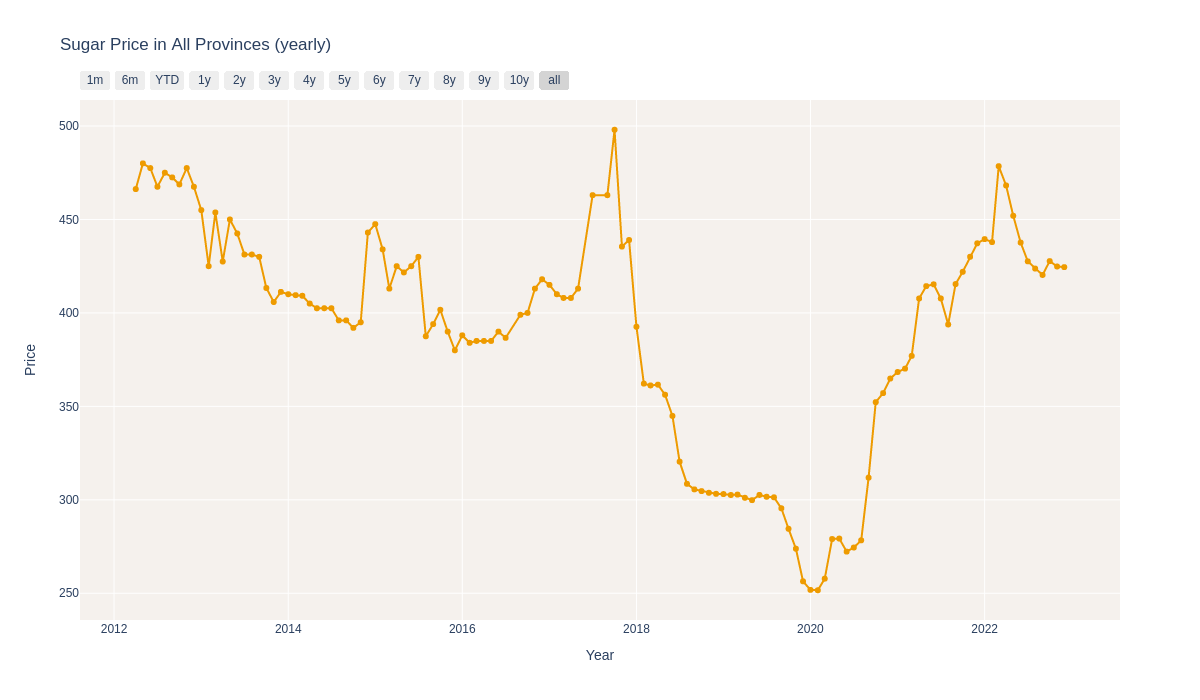

In [16]:
sugarData = data[data['Item Name']=='Sugar']
sugarData = sugarData.groupby(['Date_Month'])['Price'].mean().to_frame()
sugarData = sugarData.reset_index()

fig = go.Figure(data=go.Scatter(x=sugarData['Date_Month'].astype(dtype=str),
                                y=sugarData['Price'],
                                marker_color='#EE9B00',
                                text="counts",
                                mode='lines+markers'))

fig.update_layout(title = 'Sugar Price in All Provinces (yearly)',
                  autosize=False,
                  width=1200,
                  height=700,
                  xaxis= dict(title="Year",
                              showgrid=True,
                              showticklabels=True),
                  yaxis= dict(title="Price",
                              showgrid=True,
                              showticklabels=True,),
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(count=7, label="7y", step="year", stepmode="backward"),
            dict(count=8, label="8y", step="year", stepmode="backward"),
            dict(count=9, label="9y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show()
fig.show(renderer="png")

## Sugar Prices by Regions

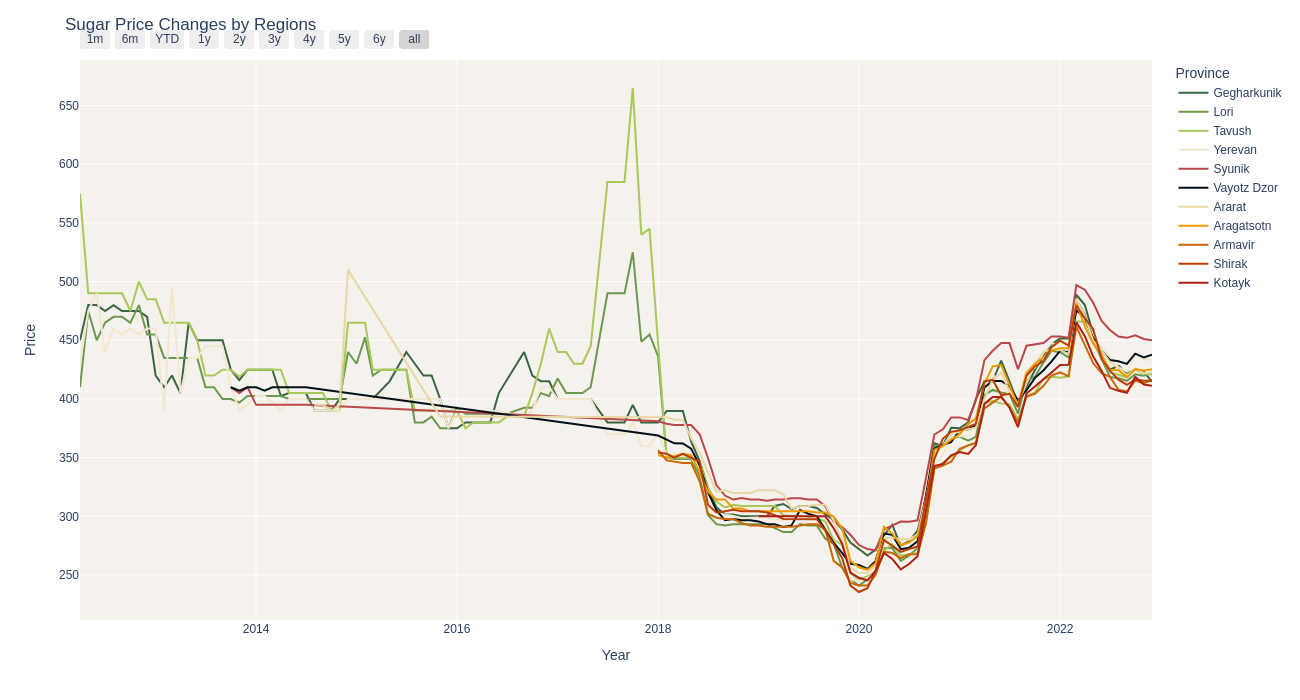

In [17]:
sugarData_regions = data[data['Item Name']=='Sugar']
sugarData_regions = sugarData_regions.groupby(['Date_Month', 'Province'])['Price'].mean().to_frame()
sugarData_regions = sugarData_regions.reset_index()

fig = px.line(sugarData_regions, x=sugarData_regions['Date_Month'].astype(dtype=str), y=sugarData_regions['Price'], color=sugarData_regions['Province'], color_discrete_sequence=colorScheme)
fig.update_layout(autosize=False,
                  width=1300,
                  height=700,
                  title = 'Sugar Price Changes by Regions',
                  xaxis={"title":"Year"},
                  yaxis= {"title":"Price"},
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show() #<- this way the graph is interactive and we have an options to choose between ranges: 1 month, 6 month etc.
fig.show(renderer="png")

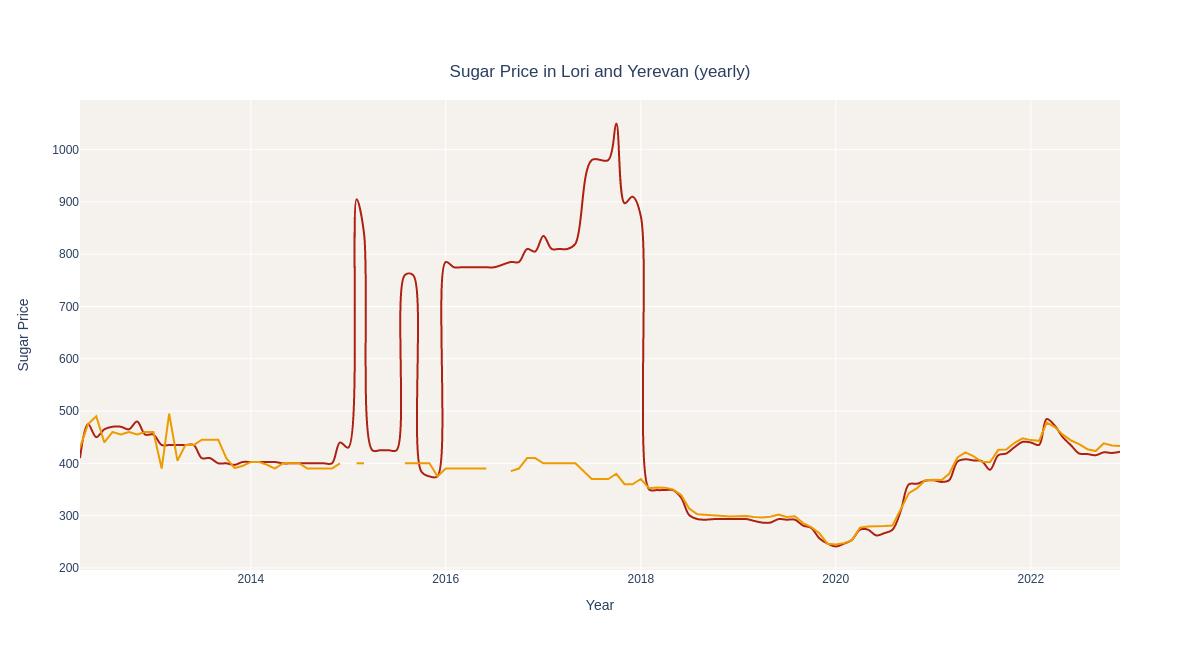

In [18]:
sugardata = data[data['Item Name']=='Sugar']
sugardata = sugardata[['Date_Month', 'Province', 'Price']]

sugar_pivot = pd.pivot_table(sugardata, values = 'Price', index=['Date_Month'], columns = ['Province'], aggfunc=np.sum)
sugar_pivot = sugar_pivot.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=sugar_pivot['Date_Month'].astype(dtype=str),
                         y=sugar_pivot['Lori'],
                         marker_color="#AE2012",
                         mode='lines',
                         line_shape='spline'))

fig.add_trace(go.Scatter(x=sugar_pivot['Date_Month'].astype(dtype=str),
                                y=sugar_pivot['Yerevan'],
                                marker_color="#EE9B00",
                                mode='lines'))

fig.update_layout(title={'text': "Sugar Price in Lori and Yerevan (yearly)",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  autosize=False,
                  width=1200,
                  height=650,
                  xaxis={"title":"Year"},
                  yaxis= {"title":"Sugar Price"},
                  showlegend=False,
                  plot_bgcolor='#f5f1ed',
                  )
fig.show(renderer='png')

## Potatoe Prices Total

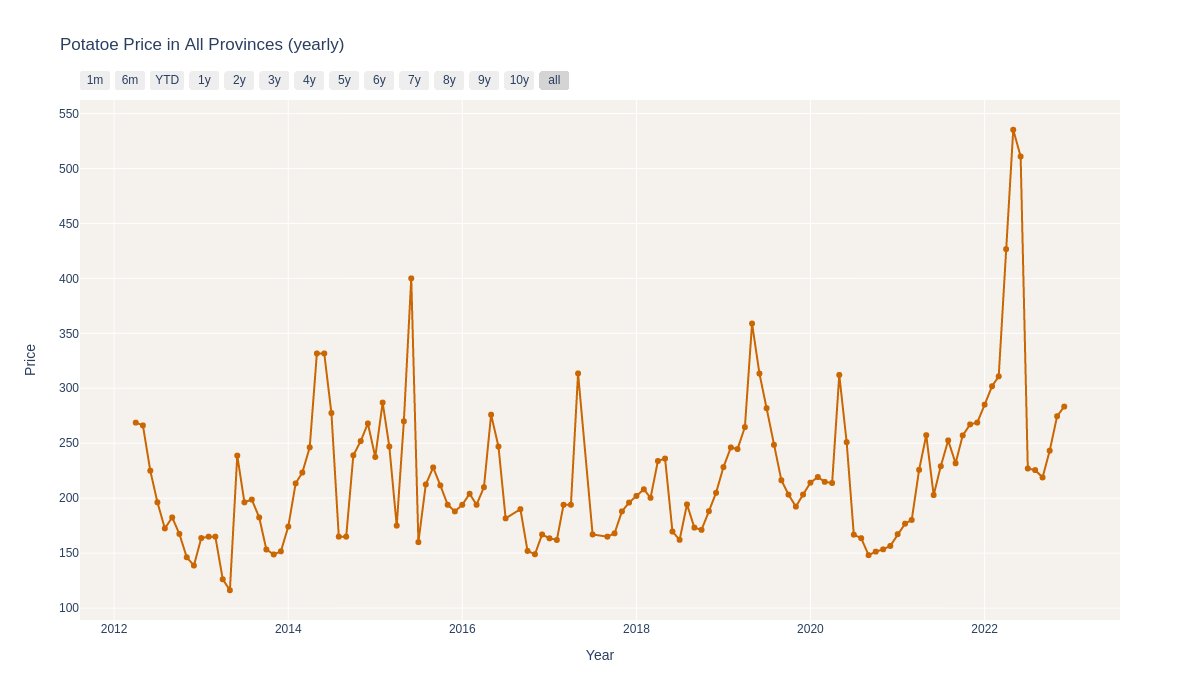

In [19]:
potatoData = data[data['Item Name']=='Potatoes']
potatoData = potatoData.groupby(['Date_Month'])['Price'].mean().to_frame()
potatoData = potatoData.reset_index()

fig = go.Figure(data=go.Scatter(x=potatoData['Date_Month'].astype(dtype=str),
                                y=potatoData['Price'],
                                marker_color='#CA6702',
                                text="counts",
                                mode='lines+markers'))

fig.update_layout(title = 'Potatoe Price in All Provinces (yearly)',
                  autosize=False,
                  width=1200,
                  height=700,
                  xaxis= dict(title="Year",
                              showgrid=True,
                              showticklabels=True),
                  yaxis= dict(title="Price",
                              showgrid=True,
                              showticklabels=True,),
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(count=7, label="7y", step="year", stepmode="backward"),
            dict(count=8, label="8y", step="year", stepmode="backward"),
            dict(count=9, label="9y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show()
fig.show(renderer="png")

## Potatoe Prices by Regions

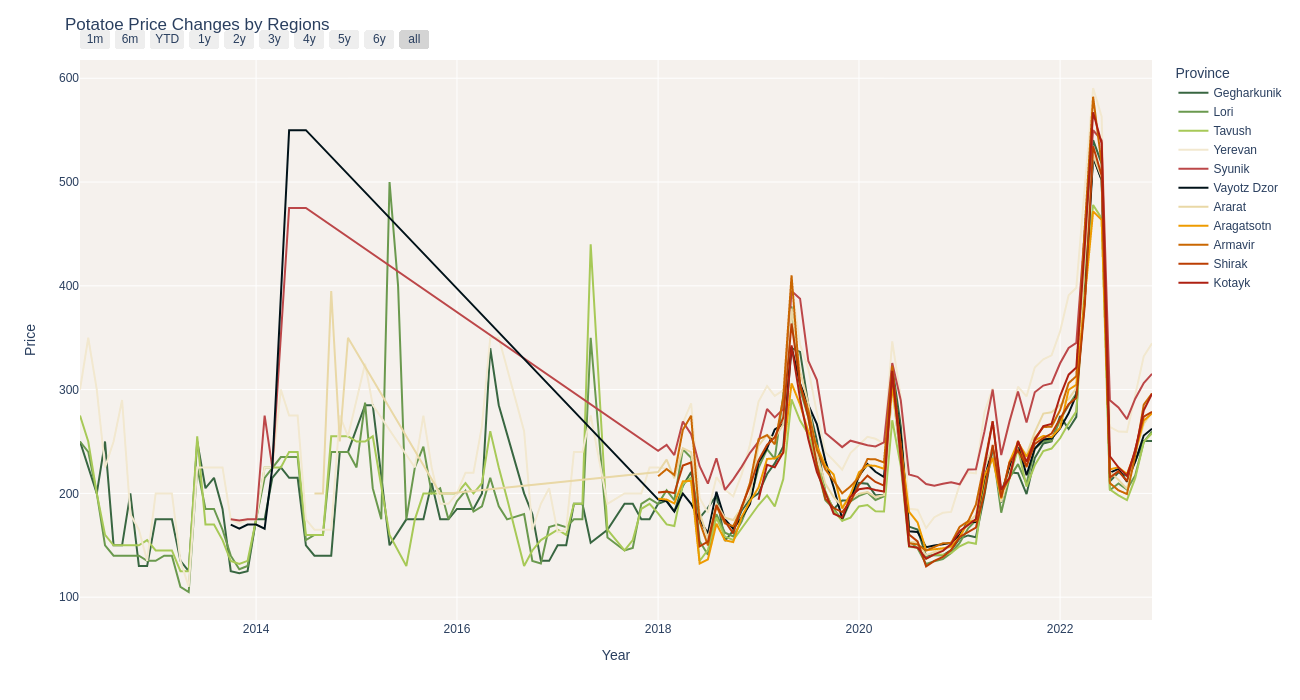

In [20]:
potatoData_regions = data[data['Item Name']=='Potatoes']
potatoData_regions = potatoData_regions.groupby(['Date_Month', 'Province'])['Price'].mean().to_frame()
potatoData_regions = potatoData_regions.reset_index()

fig = px.line(potatoData_regions, x=potatoData_regions['Date_Month'].astype(dtype=str), y=potatoData_regions['Price'], color=potatoData_regions['Province'], color_discrete_sequence=colorScheme)
fig.update_layout(autosize=False,
                  width=1300,
                  height=700,
                  title = 'Potatoe Price Changes by Regions',
                  xaxis={"title":"Year"},
                  yaxis= {"title":"Price"},
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show() #<- this way the graph is interactive and we have an options to choose between ranges: 1 month, 6 month etc.
fig.show(renderer="png")

## Egg Prices Total

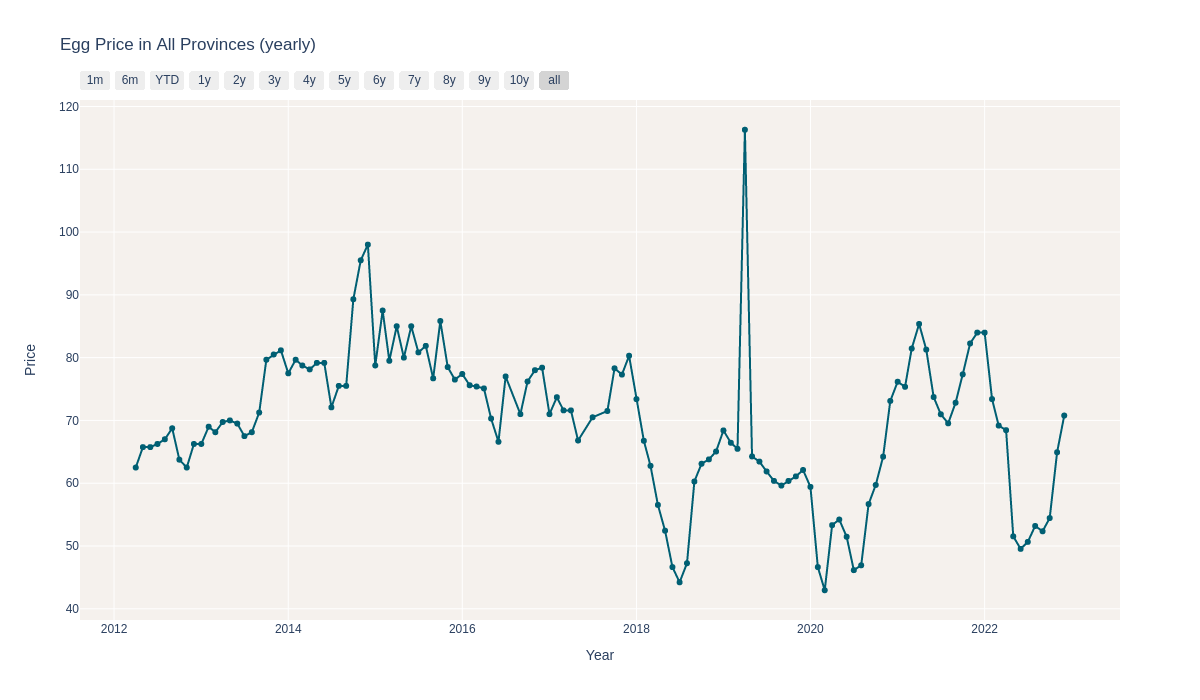

In [21]:
eggsData = data[data['Item Name']=='Eggs']
eggsData = eggsData.groupby(['Date_Month'])['Price'].mean().to_frame()
eggsData = eggsData.reset_index()

fig = go.Figure(data=go.Scatter(x=eggsData['Date_Month'].astype(dtype=str),
                                y=eggsData['Price'],
                                marker_color='#005F73',
                                text="counts",
                                mode='lines+markers'))

fig.update_layout(title = 'Egg Price in All Provinces (yearly)',
                  autosize=False,
                  width=1200,
                  height=700,
                  xaxis= dict(title="Year",
                              showgrid=True,
                              showticklabels=True),
                  yaxis= dict(title="Price",
                              showgrid=True,
                              showticklabels=True,),
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(count=7, label="7y", step="year", stepmode="backward"),
            dict(count=8, label="8y", step="year", stepmode="backward"),
            dict(count=9, label="9y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show()
fig.show(renderer="png")

## Egg Prices by Regions

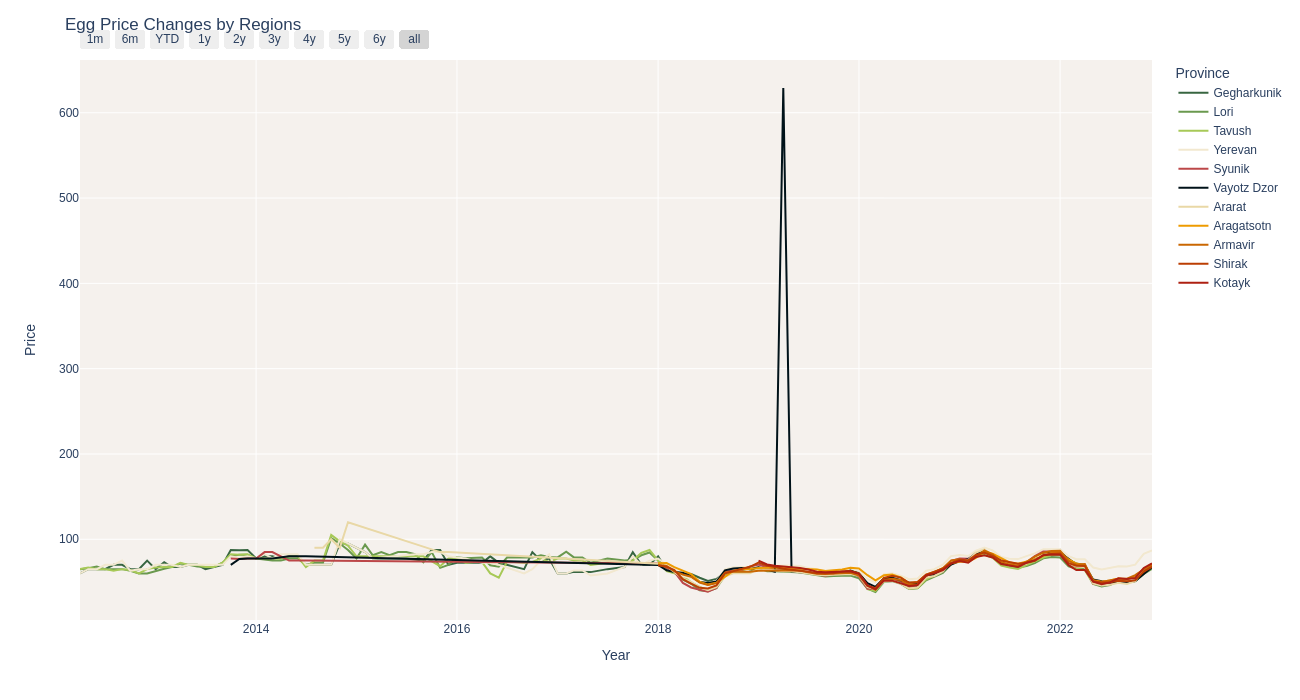

In [22]:
eggsData_regions = data[data['Item Name']=='Eggs']
eggsData_regions = eggsData_regions.groupby(['Date_Month', 'Province'])['Price'].mean().to_frame()
eggsData_regions = eggsData_regions.reset_index()

fig = px.line(eggsData_regions, x=eggsData_regions['Date_Month'].astype(dtype=str), y=eggsData_regions['Price'], color=eggsData_regions['Province'], color_discrete_sequence=colorScheme)
fig.update_layout(autosize=False,
                  width=1300,
                  height=700,
                  title = 'Egg Price Changes by Regions',
                  xaxis={"title":"Year"},
                  yaxis= {"title":"Price"},
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show() #<- this way the graph is interactive and we have an options to choose between ranges: 1 month, 6 month etc.
fig.show(renderer="png")

In [23]:
data[(data['Item Name']=='Eggs')&(data['Price']>500)]

,Date,Province,Area,Market,Latitude,Longitude,Item Category,Item Name,Unit,Priceflag,Pricetype,Currency,Price,USD_price,Year,Month,Quarter,Year_Range,Date_Month
12155,2019-04-15,Vayotz Dzor,Yeghegnadzor,Yeghegnadzor,39.76,45.33,"meat, fish and eggs",Eggs,Unit,actual,Retail,AMD,629.0,1.301,2019,April,2019Q2,4,2019-04


I guess this is an outlier.

## High Grade Bread Prices Total

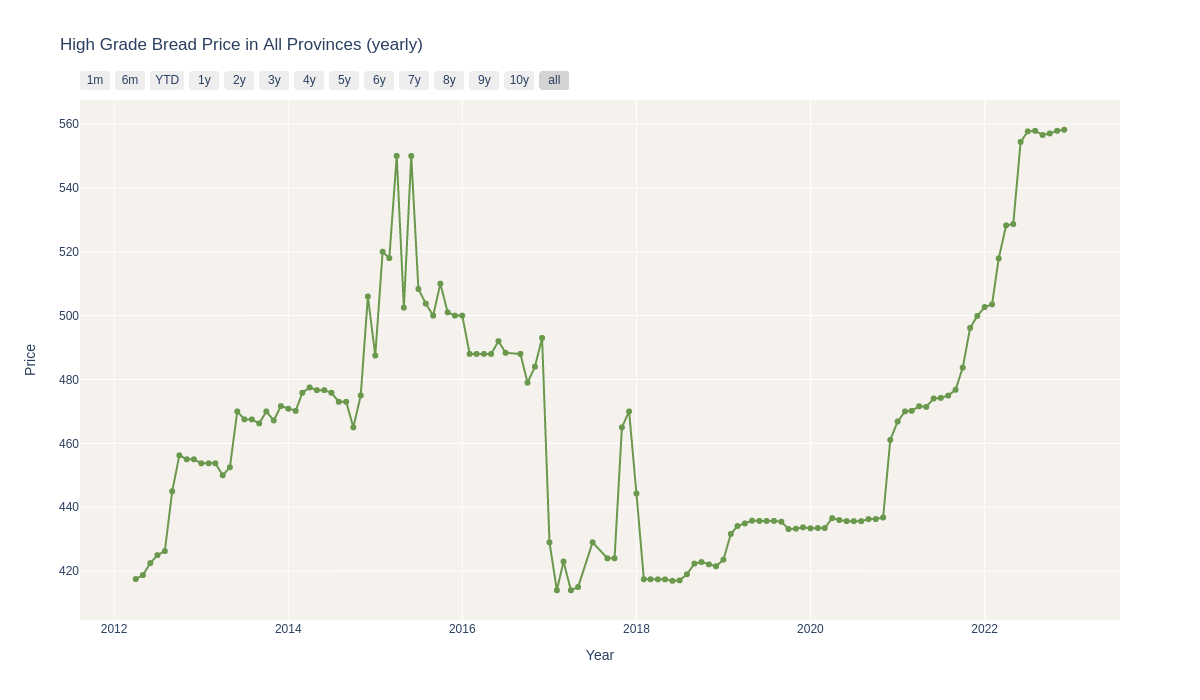

In [24]:
breadData = data[data['Item Name']=='Bread (high grade flour)']
breadData = breadData.groupby(['Date_Month'])['Price'].mean().to_frame()
breadData = breadData.reset_index()

fig = go.Figure(data=go.Scatter(x=breadData['Date_Month'].astype(dtype=str),
                                y=breadData['Price'],
                                marker_color='#6A994E',
                                text="counts",
                                mode='lines+markers'))

fig.update_layout(title = 'High Grade Bread Price in All Provinces (yearly)',
                  autosize=False,
                  width=1200,
                  height=700,
                  xaxis= dict(title="Year",
                              showgrid=True,
                              showticklabels=True),
                  yaxis= dict(title="Price",
                              showgrid=True,
                              showticklabels=True,),
                  plot_bgcolor='#f5f1ed')

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=4, label="4y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=6, label="6y", step="year", stepmode="backward"),
            dict(count=7, label="7y", step="year", stepmode="backward"),
            dict(count=8, label="8y", step="year", stepmode="backward"),
            dict(count=9, label="9y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")])))

# fig.show()
fig.show(renderer="png")

In [25]:
myFaveColorScheme = [{"dark blue": '#001219'}, {"ocean blue": '#005F73'}, {"cyan": '#0A9396'},
                     {"lighter green": '#94D2BD'}, {"light yellow": '#E9D8A6'}, {"orange": '#EE9B00'},
                     {"carrot": '#CA6702'}, {"red": '#BB3E03'}, {"christmas red": '#AE2012'},
                     {"dark red": '#9B2226'}, {"dark green": '#386641'}, {'grass green': '#6A994E'},
                     {'light green': '#A7C957'}, {'beige': '#F2E8CF'}, {'light green': '#blush red'},
                     {'blackest blue': '#001219'}]

In [26]:
data.groupby(['Item Category', 'Item Name'])['Market'].count().to_frame()

Market
Item Category         Item Name                        
cereals and tubers    Bread (first grade flour)     842
                      Bread (high grade flour)      951
                      Buckwheat                     648
                      Pasta                         951
                      Potatoes                      950
                      Rice (white)                  999
                      Wheat flour                   549
meat, fish and eggs   Eggs                          951
                      Fish (fresh)                  949
                      Meat (beef)                   950
                      Meat (chicken)                950
                      Meat (pork)                   950
milk and dairy        Cheese (dry)                  950
                      Milk                          950
                      Milk (non-pasteurized)        220
miscellaneous food    Salt                          648
                      Sugar                         950
                      Tomatoes (paste)              648
non-food              Exchange rate                  38
                      Fuel (diesel)                 972
                      Fuel (kerosene)               112
                      Fuel (petrol-gasoline)       1047
oil and fats          Butter                        132
                      Oil (vegetable)               951
pulses and nuts       Beans                         648
                      Lentils                       951
                      Peas (split, dry)             648
vegetables and fruits Apples (red)                  950
                      Beetroots                     648
                      Cabbage                       950
                      Carrots                       950
                      Cucumbers (greenhouse)        950
                      Onions                        950
                      Tomatoes                      950